# Funnel Analysis


## Data Summary  
Overall open→disbursed conversion is **47.5%** (4,753 / 10,000 users). The largest drop-offs are at **open→link (28.1%)**, **request→approved (23.9%)**, and **link→request (13.2%)**.  

## P75 Incremental Disbursement  
If underperforming segments were lifted to the **75th percentile benchmark (P75)**, Bree could add:  

- **+515 loan disbursements** at link→request (+51 per 1k opens)  
- **+384 loan disbursements** at request→approved (+38 per 1k)  
- **+219 loan disbursements** at open→link (+22 per 1k)  

The **approved→disbursed** step shows no headroom. P75 is realistic because top-performing segments already achieve these rates today.  

## Top 3 Friction Points  
Largest opportunities sit in Ontario organic segments:  
- **Request→Approved (ON · Android · Organic):** **+54 loan disbursements** (~62 per 1k opens)  
- **Link→Request (ON · iOS · Organic):** **+47 loan disbursements** (~55 per 1k)  
- **Link→Request (ON · Android · Organic):** **+37 loan disbursements** (~43 per 1k)  

This shows that **approval policy/modeling** and **loan request UX** are the most critical levers to unlock incremental growth for Ontario organic users.  

## Conversion by signup month 
Only the link→request conversion shifted while other steps stayed flat, this points to a product change in the request flow rather than user mix or seasonality. Possible drivers include how loan amounts, tips, or fees were presented, the addition of a new UI step, or stricter criteria shown earlier in the process. The impact was negative, cutting open→disbursed conversion nearly in half. Bree should investigate what changed in the request experience around month 7, run A/B or cohort backtests comparing the old vs. new design, and if necessary roll back or redesign to reduce the psychological or UX friction introduced.

## Additional Insight  
Email customers have the **lowest link→request conversion (82.7%)** but the **highest request→approval (79%)**. Bree targets them well from a risk perspective, but many don’t request loans after linking — likely because **loan amounts offered feel too low**.  

## Personal Experience (validating friction points)  
- **Bank linking:** Wealthsimple not supported by Flinks → had to connect an unused card.  
- **Loan amount:** Very low offer (due to limited history), not meaningful enough.  
- **Tip amount:** Default 15% tip felt psychologically high and discouraging.  

---

## Recommendations with Action Items  

### 1. Improve Bank Connection (targets open→link + request→approved)  
- **Expand bank coverage**: Consider adding more connectors beyond Flinks to support institutions like Wealthsimple.  
- **Allow multiple cards**: Let users connect more than one card and nudge them — larger combined history increases loan amounts and strengthens internal risk models.  
- **Reduce wait-time drop-offs**: While bank linking processes, display Bree info, testimonials, or progress messages so customers don’t leave out of boredom.  

### 2. Reduce Psychological Burden on Fees (targets link→request)  
- **Rethink tip defaults**: Bree should experiment with different ways of presenting or defaulting tips to understand and reduce psychological friction. For example, **15% on a $100 loan may feel expensive, but $2 on $100 may not.**  
- **A/B test instant fees**: Run experiments with varying instant fee levels to identify which structures maximize incremental disbursements while maintaining profitability.  

### 3. Refine Internal Models (targets request→approved)  
- **Relax approval criteria strategically**: Adjust thresholds for borderline applicants to improve conversion while still controlling risk.  
- **Optimize with more data**: Use expanded bank connections and transaction history to better differentiate risk and safely approve more customers.  

### 4. Channel-Specific Action — Organic Ontario  
- **Conduct surveys** with users in this segment to better understand why they drop after linking and don’t proceed to request.  
- Use findings to refine both **approval model tuning** and **request UX improvements**, since this segment has the highest incremental upside.  


In [15]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Connect to database
conn = duckdb.connect('../bree_case_study.db')

## Overall Funnel Analysis

Overall open→disbursed conversion is 47.5%. The largest drop-off occurs at open→link (28.1%), followed by request→approved (23.9%), and then link→request (13.2%). This highlights bank linking and approval as the two biggest friction points in the funnel.

In [16]:
# show overall funnel metrics:

overall_funnel_query = """
WITH totals AS (
  SELECT
    SUM(app_open_users)      AS open_cnt,
    SUM(bank_linked_users)   AS link_cnt,
    SUM(requested_users)     AS request_cnt,
    SUM(approved_users)      AS approved_cnt,
    SUM(disbursed_users)     AS disbursed_cnt
  FROM v_funnel_by_segment
),
steps AS (
  SELECT 'open→link' AS step, open_cnt  AS from_cnt, link_cnt      AS to_cnt FROM totals
  UNION ALL
  SELECT 'link→request',       link_cnt,     request_cnt                    FROM totals
  UNION ALL
  SELECT 'request→approved',   request_cnt,  approved_cnt                   FROM totals
  UNION ALL
  SELECT 'approved→disbursed', approved_cnt, disbursed_cnt                  FROM totals
),
final AS (
  SELECT
    step,
    from_cnt,
    to_cnt,
    CASE WHEN from_cnt > 0 THEN to_cnt::DOUBLE / from_cnt ELSE 0 END AS conversion_rate,
    (from_cnt - to_cnt) AS dropoff_count,
    CASE WHEN from_cnt > 0 THEN (from_cnt - to_cnt)::DOUBLE / from_cnt ELSE 0 END AS dropoff_rate
  FROM steps
)
SELECT * FROM final
UNION ALL
SELECT
  'open→disbursed (absolute)' AS step,
  open_cnt AS from_cnt,
  disbursed_cnt AS to_cnt,
  CASE WHEN open_cnt > 0 THEN disbursed_cnt::DOUBLE / open_cnt ELSE 0 END AS conversion_rate,
  (open_cnt - disbursed_cnt) AS dropoff_count,
  CASE WHEN open_cnt > 0 THEN (open_cnt - disbursed_cnt)::DOUBLE / open_cnt ELSE 0 END AS dropoff_rate
FROM totals;
"""

overall_df = conn.execute(overall_funnel_query).fetchdf()
print("Overall Funnel Metrics:")
display(overall_df)


Overall Funnel Metrics:


,step,from_cnt,to_cnt,conversion_rate,dropoff_count,dropoff_rate
0,open→link,10000.0,7195.0,0.719500,2805.0,0.280500
1,link→request,7195.0,6245.0,0.867964,950.0,0.132036
2,request→approved,6245.0,4753.0,0.761089,1492.0,0.238911
3,approved→disbursed,4753.0,4753.0,1.000000,0.0,0.000000
4,open→disbursed (absolute),10000.0,4753.0,0.475300,5247.0,0.524700


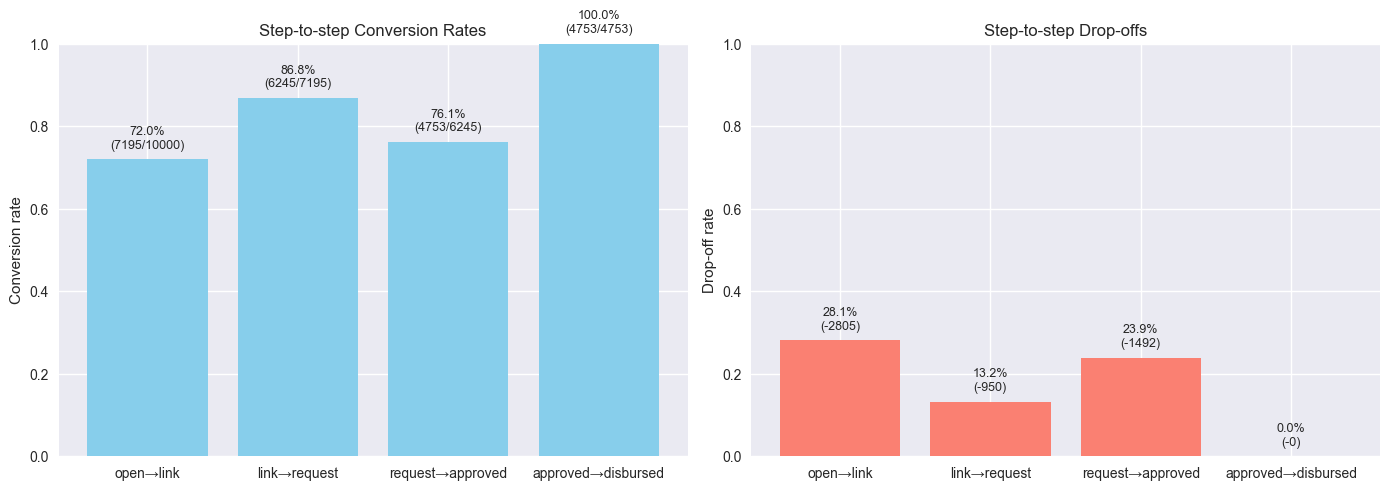

In [17]:
import matplotlib.pyplot as plt

plot_df = overall_df.iloc[:4].copy()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Left: Conversion rates ---
bars1 = axes[0].bar(plot_df['step'], plot_df['conversion_rate'], color='skyblue')
axes[0].set_ylim(0,1)
axes[0].set_ylabel("Conversion rate")
axes[0].set_title("Step-to-step Conversion Rates")
for bar, conv, from_cnt, to_cnt in zip(bars1, plot_df['conversion_rate'], plot_df['from_cnt'], plot_df['to_cnt']):
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
                 f"{conv:.1%}\n({int(to_cnt)}/{int(from_cnt)})",
                 ha='center', va='bottom', fontsize=9)

# --- Right: Drop-off rates ---
bars2 = axes[1].bar(plot_df['step'], plot_df['dropoff_rate'], color='salmon')
axes[1].set_ylim(0,1)
axes[1].set_ylabel("Drop-off rate")
axes[1].set_title("Step-to-step Drop-offs")
for bar, drop_rate, drop_cnt in zip(bars2, plot_df['dropoff_rate'], plot_df['dropoff_count']):
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
                 f"{drop_rate:.1%}\n(-{int(drop_cnt)})",
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### P75 Incremental Disbursement

P75 Incremental Disbursement
This shows the increment in disbursements if the bottom 75% of segments were lifted to the conversion rates of the top 25% (P75 benchmark). This is a reasonable assumption because those higher conversion rates are already being achieved by some segments today, making them a practical best-practice target rather than a theoretical maximum.

Under this lens, the largest lever is link→request, followed by request→approved, and then open→link. The approved→disbursed step has little to no headroom.

Focus areas:

Link→request – address pricing/tip/fee shock and UX clarity.

Request→approved – refine approval policy and risk modeling, especially for weaker segments.

Open→link – improve bank-link reliability and user trust (e.g., Flinks coverage, latency, security cues).

In [18]:
p75_levers_sql = """
-- 1) Collapse to segment-level totals (ignore signup_month/year)
WITH seg_tot AS (
  SELECT
    province,
    device_os,
    acquisition_channel,
    SUM(app_open_users)    AS n1,  -- open
    SUM(bank_linked_users) AS n2,  -- link
    SUM(requested_users)   AS n3,  -- request
    SUM(approved_users)    AS n4,  -- approved
    SUM(disbursed_users)   AS n5   -- disbursed
  FROM v_funnel_by_segment
  GROUP BY 1,2,3
),

-- 2) Compute guarded step rates per segment
seg AS (
  SELECT
    province, device_os, acquisition_channel,
    n1, n2, n3, n4, n5,
    GREATEST(0.0, LEAST(n2::DOUBLE/NULLIF(n1,0), 1.0)) AS r12,
    GREATEST(0.0, LEAST(n3::DOUBLE/NULLIF(n2,0), 1.0)) AS r23,
    GREATEST(0.0, LEAST(n4::DOUBLE/NULLIF(n3,0), 1.0)) AS r34,
    GREATEST(0.0, LEAST(n5::DOUBLE/NULLIF(n4,0), 1.0)) AS r45
  FROM seg_tot
),

-- 3) P75 targets across segments (cap at 0.95)
p75 AS (
  SELECT
    quantile_cont(r12, 0.75) AS p75_r12,
    quantile_cont(r23, 0.75) AS p75_r23,
    quantile_cont(r34, 0.75) AS p75_r34,
    quantile_cont(r45, 0.75) AS p75_r45
  FROM seg
),
targets AS (
  SELECT
    LEAST(p75_r12, 0.95) AS t12,
    LEAST(p75_r23, 0.95) AS t23,
    LEAST(p75_r34, 0.95) AS t34,
    LEAST(p75_r45, 0.95) AS t45
  FROM p75
),

-- 4) Simulate one-step lift to target, holding downstream rates constant
opps AS (
  -- open→link
  SELECT 'open→link' AS step, s.*,
         (s.n1 * t.t12)                       AS n2p,
         (s.n1 * t.t12 * s.r23)               AS n3p,
         (s.n1 * t.t12 * s.r23 * s.r34)       AS n4p,
         (s.n1 * t.t12 * s.r23 * s.r34 * s.r45) AS n5p
  FROM seg s CROSS JOIN targets t
  UNION ALL
  -- link→request
  SELECT 'link→request', s.*,
         s.n2,
         (s.n2 * t.t23),
         (s.n2 * t.t23 * s.r34),
         (s.n2 * t.t23 * s.r34 * s.r45)
  FROM seg s CROSS JOIN targets t
  UNION ALL
  -- request→approved
  SELECT 'request→approved', s.*,
         s.n2,
         s.n3,
         (s.n3 * t.t34),
         (s.n3 * t.t34 * s.r45)
  FROM seg s CROSS JOIN targets t
  UNION ALL
  -- approved→disbursed
  SELECT 'approved→disbursed', s.*,
         s.n2,
         s.n3,
         s.n4,
         (s.n4 * t.t45)
  FROM seg s CROSS JOIN targets t
),

-- 5) Per-segment impact + normalization
by_segment AS (
  SELECT
    step,
    province, device_os, acquisition_channel,
    n1, n2, n3, n4, n5,
    r12, r23, r34, r45,
    n5p,
    GREATEST(0.0, n5p - n5) AS incremental_disbursed
  FROM opps
  WHERE n1 > 0
),

-- 6) Aggregate to overall step impact
summary AS (
  SELECT
    step,
    SUM(incremental_disbursed) AS incremental_disbursed_dataset,
    SUM(n1)                    AS open_cnt_sum
  FROM by_segment
  GROUP BY 1
)

-- 7) Final output
SELECT
  step,
  ROUND(incremental_disbursed_dataset, 3)                                       AS incremental_disbursed_dataset,
  ROUND(incremental_disbursed_dataset / NULLIF(open_cnt_sum,0) * 1000, 3)       AS incremental_per_1k_opens
FROM summary
ORDER BY incremental_disbursed_dataset DESC;
"""

p75_levers_df = conn.execute(p75_levers_sql).fetchdf()
display(p75_levers_df)


,step,incremental_disbursed_dataset,incremental_per_1k_opens
0,link→request,514.590,51.459
1,request→approved,384.182,38.418
2,open→link,218.996,21.900
3,approved→disbursed,0.000,0.000


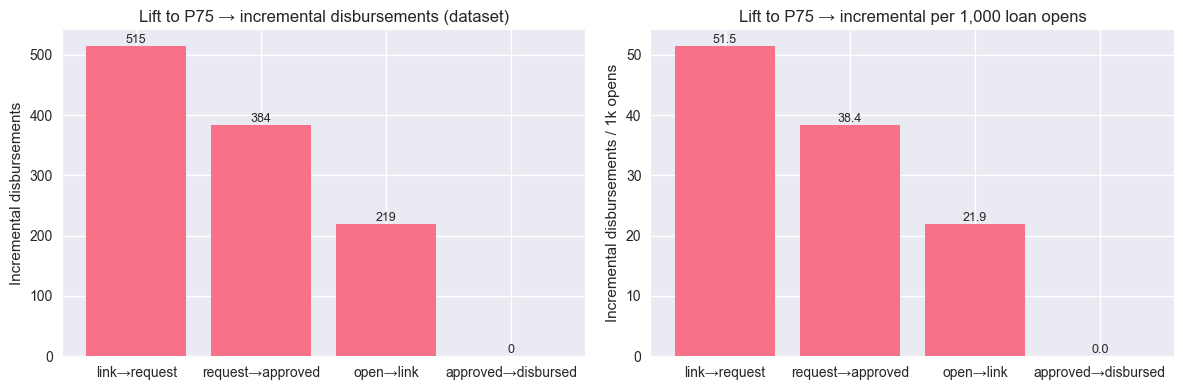

In [19]:
import matplotlib.pyplot as plt

plot_df = p75_levers_df.copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: total incremental disbursements (dataset scope)
axes[0].bar(plot_df["step"], plot_df["incremental_disbursed_dataset"])
axes[0].set_title("Lift to P75 → incremental disbursements (dataset)")
axes[0].set_ylabel("Incremental disbursements")
for i, v in enumerate(plot_df["incremental_disbursed_dataset"]):
    axes[0].text(i, v, f"{v:.0f}", ha='center', va='bottom', fontsize=9)

# Right: normalized per 1k opens
axes[1].bar(plot_df["step"], plot_df["incremental_per_1k_opens"])
axes[1].set_title("Lift to P75 → incremental per 1,000 loan opens")
axes[1].set_ylabel("Incremental disbursements / 1k opens")
for i, v in enumerate(plot_df["incremental_per_1k_opens"]):
    axes[1].text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Top 3 friction points (by incremental disbursements if lifted to P75 targets*)

The biggest incremental gains come from Ontario · Organic segments. Specifically:

Request→Approved (ON · Android · Organic): +54 disbursements (~62 per 1k opens)

Link→Request (ON · iOS · Organic): +47 disbursements (~55 per 1k opens)

Link→Request (ON · Android · Organic): +37 disbursements (~43 per 1k opens)

👉 This shows that approval policy/modeling and link→request UX/fee clarity are the most critical levers to unlock additional disbursements.

In [20]:
top3_p75_sql = """
-- 1) Collapse to segment-level totals (ignore cohort fields)
WITH seg_tot AS (
  SELECT
    province,
    device_os,
    acquisition_channel,
    SUM(app_open_users)    AS n1,  -- open
    SUM(bank_linked_users) AS n2,  -- link
    SUM(requested_users)   AS n3,  -- request
    SUM(approved_users)    AS n4,  -- approved
    SUM(disbursed_users)   AS n5   -- disbursed
  FROM v_funnel_by_segment
  GROUP BY 1,2,3
),

-- 2) Compute guarded step rates per segment
seg AS (
  SELECT
    province, device_os, acquisition_channel,
    n1, n2, n3, n4, n5,
    GREATEST(0.0, LEAST(n2::DOUBLE/NULLIF(n1,0), 1.0)) AS r12,
    GREATEST(0.0, LEAST(n3::DOUBLE/NULLIF(n2,0), 1.0)) AS r23,
    GREATEST(0.0, LEAST(n4::DOUBLE/NULLIF(n3,0), 1.0)) AS r34,
    GREATEST(0.0, LEAST(n5::DOUBLE/NULLIF(n4,0), 1.0)) AS r45
  FROM seg_tot
),

-- 3) P75 targets (cap at 0.95)
p75 AS (
  SELECT
    quantile_cont(r12, 0.75) AS p75_r12,
    quantile_cont(r23, 0.75) AS p75_r23,
    quantile_cont(r34, 0.75) AS p75_r34,
    quantile_cont(r45, 0.75) AS p75_r45
  FROM seg
),
targets AS (
  SELECT
    LEAST(p75_r12, 0.95) AS t12,
    LEAST(p75_r23, 0.95) AS t23,
    LEAST(p75_r34, 0.95) AS t34,
    LEAST(p75_r45, 0.95) AS t45
  FROM p75
),

-- 4) Simulate one-step lift to target (downstream rates held constant)
opps AS (
  -- open→link
  SELECT 'open→link' AS step, s.*,
         (s.n1 * t.t12 * s.r23 * s.r34 * s.r45) AS n5p
  FROM seg s CROSS JOIN targets t
  UNION ALL
  -- link→request
  SELECT 'link→request', s.*,
         (s.n2 * t.t23 * s.r34 * s.r45) AS n5p
  FROM seg s CROSS JOIN targets t
  UNION ALL
  -- request→approved
  SELECT 'request→approved', s.*,
         (s.n3 * t.t34 * s.r45) AS n5p
  FROM seg s CROSS JOIN targets t
  UNION ALL
  -- approved→disbursed
  SELECT 'approved→disbursed', s.*,
         (s.n4 * t.t45) AS n5p
  FROM seg s CROSS JOIN targets t
),

-- 5) Rank impacts
ranked AS (
  SELECT
    step,
    province, device_os, acquisition_channel,
    n1, n5, n5p,
    GREATEST(0.0, n5p - n5) AS incremental_disbursed,
    CASE WHEN n1>0 THEN (n5p - n5)/n1*1000 ELSE 0 END AS incremental_per_1k_opens
  FROM opps
)
SELECT
  step,
  province, device_os, acquisition_channel,
  ROUND(incremental_disbursed, 3)      AS incremental_disbursed,
  ROUND(incremental_per_1k_opens, 3)   AS incremental_per_1k_opens
FROM ranked
ORDER BY incremental_disbursed DESC
LIMIT 3;
"""

top3_df = conn.execute(top3_p75_sql).fetchdf()
display(top3_df)


,step,province,device_os,acquisition_channel,incremental_disbursed,incremental_per_1k_opens
0,request→approved,ON,android,organic,53.727,62.184
1,link→request,ON,ios,organic,46.590,54.556
2,link→request,ON,android,organic,36.999,42.823


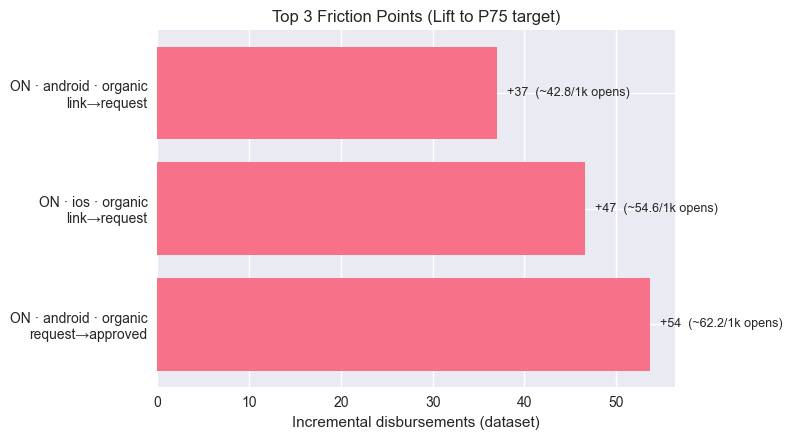

In [21]:
import matplotlib.pyplot as plt

plot_df = top3_df.copy()
plot_df["label"] = (
    plot_df["province"] + " · " + plot_df["device_os"] + " · " +
    plot_df["acquisition_channel"] + "\n" + plot_df["step"]
)

fig, ax = plt.subplots(figsize=(8,4.5))
bars = ax.barh(plot_df["label"], plot_df["incremental_disbursed"])

ax.set_xlabel("Incremental disbursements (dataset)")
ax.set_title("Top 3 Friction Points (Lift to P75 target)")

for bar, inc, per1k in zip(bars, plot_df["incremental_disbursed"], plot_df["incremental_per_1k_opens"]):
    ax.text(bar.get_width()+max(plot_df["incremental_disbursed"])*0.02,
            bar.get_y()+bar.get_height()/2,
            f"+{inc:.0f}  (~{per1k:.1f}/1k opens)",
            va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Interesting Insight I came across
One interesting insight is around the Email channel. Customers acquired via email show the lowest link→request conversion (82.7%) but the highest request→approval conversion (79%). This suggests Bree’s risk model views email customers as less risky, and the targeting works well compared to other channels. However, many of these customers don’t proceed to request a loan even after linking their bank, likely because the loan amounts offered are too low to be attractive.

In [22]:
sql_by_channel = """
WITH agg AS (
  SELECT
    acquisition_channel,
    SUM(bank_linked_users)   AS link_cnt,
    SUM(requested_users)     AS request_cnt,
    SUM(approved_users)      AS approved_cnt
  FROM v_funnel_by_segment
  GROUP BY 1
)
SELECT
  acquisition_channel,
  -- link → request
  request_cnt                                           AS requests,
  link_cnt                                              AS bank_links,
  CASE WHEN link_cnt > 0 THEN request_cnt::DOUBLE / link_cnt ELSE 0 END
    AS r_link_to_request,
  -- request → approved
  approved_cnt                                          AS approvals,
  CASE WHEN request_cnt > 0 THEN approved_cnt::DOUBLE / request_cnt ELSE 0 END
    AS r_request_to_approved
FROM agg
ORDER BY r_request_to_approved DESC, r_link_to_request DESC;
"""

by_channel = conn.execute(sql_by_channel).fetchdf()
display(by_channel)


,acquisition_channel,requests,bank_links,r_link_to_request,approvals,r_request_to_approved
0,email,287.0,347.0,0.827089,227.0,0.790941
1,paid_search,778.0,887.0,0.877114,598.0,0.768638
2,organic,2801.0,3252.0,0.861316,2147.0,0.766512
3,affiliate,650.0,738.0,0.880759,498.0,0.766154
4,paid_social,1096.0,1252.0,0.875399,828.0,0.755474
5,referral,633.0,719.0,0.880389,455.0,0.718799


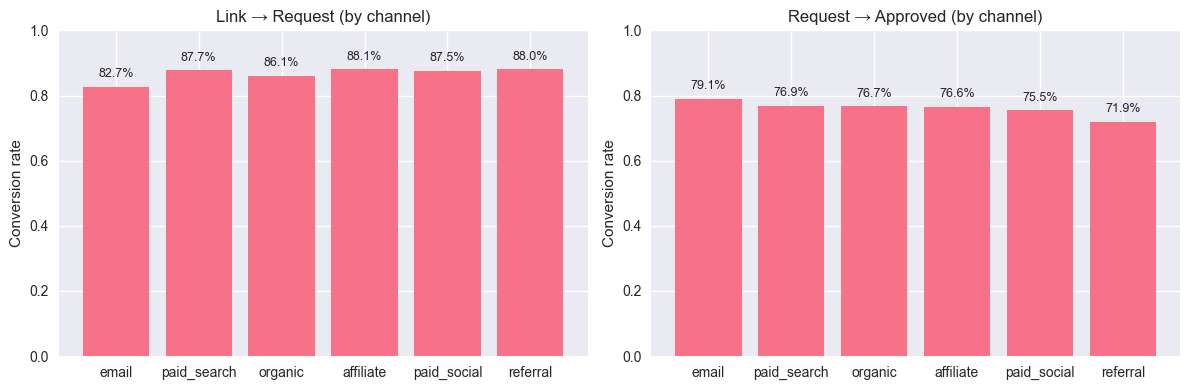

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,4))

axes[0].bar(by_channel["acquisition_channel"], by_channel["r_link_to_request"])
axes[0].set_title("Link → Request (by channel)")
axes[0].set_ylabel("Conversion rate")
axes[0].set_ylim(0,1)
for i, v in enumerate(by_channel["r_link_to_request"]):
    axes[0].text(i, v+0.02, f"{v:.1%}", ha="center", va="bottom", fontsize=9)

axes[1].bar(by_channel["acquisition_channel"], by_channel["r_request_to_approved"])
axes[1].set_title("Request → Approved (by channel)")
axes[1].set_ylabel("Conversion rate")
axes[1].set_ylim(0,1)
for i, v in enumerate(by_channel["r_request_to_approved"]):
    axes[1].text(i, v+0.02, f"{v:.1%}", ha="center", va="bottom", fontsize=9)

plt.tight_layout(); plt.show()


# Conversion - Cohort by signup month

In [24]:
cohort_sql = """
WITH coh AS (
  SELECT
    signup_year,
    signup_month,
    SUM(app_open_users)      AS open_cnt,
    SUM(bank_linked_users)   AS link_cnt,
    SUM(requested_users)     AS request_cnt,
    SUM(approved_users)      AS approved_cnt,
    SUM(disbursed_users)     AS disbursed_cnt
  FROM v_funnel_by_segment
  GROUP BY signup_year, signup_month
)
SELECT
  signup_year,
  signup_month,
  open_cnt, link_cnt, request_cnt, approved_cnt, disbursed_cnt,
  CASE WHEN open_cnt>0     THEN link_cnt::DOUBLE/open_cnt     ELSE 0 END AS r_open_to_link,
  CASE WHEN link_cnt>0     THEN request_cnt::DOUBLE/link_cnt  ELSE 0 END AS r_link_to_request,
  CASE WHEN request_cnt>0  THEN approved_cnt::DOUBLE/request_cnt ELSE 0 END AS r_request_to_approved,
  CASE WHEN approved_cnt>0 THEN disbursed_cnt::DOUBLE/approved_cnt ELSE 0 END AS r_approved_to_disbursed,
  CASE WHEN open_cnt>0     THEN disbursed_cnt::DOUBLE/open_cnt ELSE 0 END AS r_open_to_disbursed
FROM coh
ORDER BY signup_year, signup_month;
"""

cohort_df = conn.execute(cohort_sql).fetchdf()
display(cohort_df.head())


,signup_year,signup_month,open_cnt,link_cnt,request_cnt,approved_cnt,disbursed_cnt,r_open_to_link,r_link_to_request,r_request_to_approved,r_approved_to_disbursed,r_open_to_disbursed
0,2024,12,49.0,35.0,32.0,22.0,22.0,0.714286,0.914286,0.687500,1.0,0.448980
1,2025,1,1464.0,1044.0,1009.0,804.0,804.0,0.713115,0.966475,0.796829,1.0,0.549180
2,2025,2,1308.0,910.0,907.0,699.0,699.0,0.695719,0.996703,0.770673,1.0,0.534404
3,2025,3,1474.0,1074.0,984.0,746.0,746.0,0.728630,0.916201,0.758130,1.0,0.506106
4,2025,4,1444.0,1047.0,1030.0,802.0,802.0,0.725069,0.983763,0.778641,1.0,0.555402


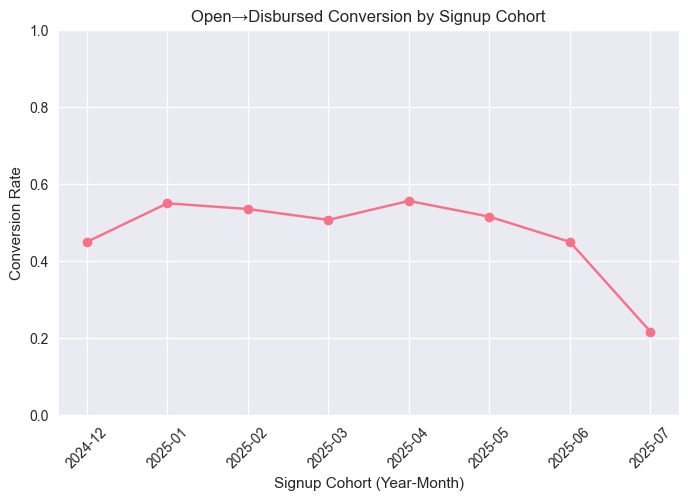

In [25]:
import matplotlib.pyplot as plt

# Create year-month label for x-axis
cohort_df["signup_period"] = cohort_df["signup_year"].astype(str) + "-" + cohort_df["signup_month"].astype(str).str.zfill(2)

plt.figure(figsize=(8,5))
plt.plot(cohort_df["signup_period"], cohort_df["r_open_to_disbursed"], marker="o")
plt.title("Open→Disbursed Conversion by Signup Cohort")
plt.xlabel("Signup Cohort (Year-Month)")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


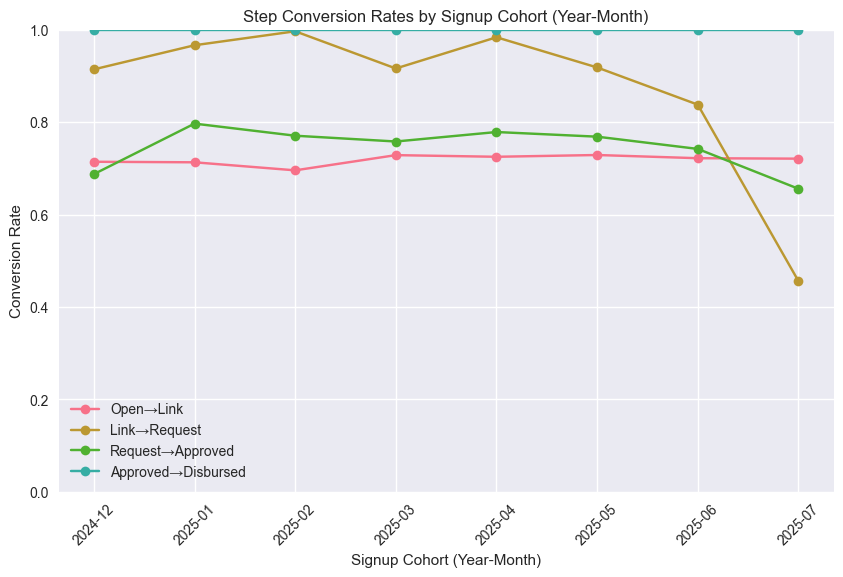

In [26]:
# Create year-month label if not already in the dataframe
cohort_df["signup_period"] = (
    cohort_df["signup_year"].astype(str) + "-" +
    cohort_df["signup_month"].astype(str).str.zfill(2)
)

steps = [
    ("r_open_to_link", "Open→Link"),
    ("r_link_to_request", "Link→Request"),
    ("r_request_to_approved", "Request→Approved"),
    ("r_approved_to_disbursed", "Approved→Disbursed"),
]

plt.figure(figsize=(10,6))
for col, label in steps:
    plt.plot(cohort_df["signup_period"], cohort_df[col], marker="o", label=label)

plt.title("Step Conversion Rates by Signup Cohort (Year-Month)")
plt.xlabel("Signup Cohort (Year-Month)")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.legend()
plt.show()


Because only link→request conversion moves, while the other steps are flat, this points to a product change around the request flow rather than user mix or external seasonality.

Examples: changes in how loan amounts, tips, or fees were presented; a new UI step before request; or stricter criteria shown earlier in the flow.

The effect was negative, cutting open→disbursed conversion in half.

In [27]:
conn.close()